In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
import statsmodels.api as sm
import math
import csv
import datetime as dt
import statsmodels.regression.linear_model as linreg
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.regression.linear_model import WLS

In this HW we construct a 2-stage regression for predicting hedged CDS
spread “returns” using boxcar and discounted least squares for the predictive
phase, and compare the two.

## 1. Data

* Weekly Wednesday to Wednesday return on CDS Spreads

In [197]:
def process_cds_dataset():
    # Read and select initial columns
    cds_data = pd.read_csv('Liq5YCDS.delim', sep='\t')
    cds_data = cds_data.loc[:, ['date', 'ticker', 'parspread']]
    
    # Create groups of tickers by date
    daily_tickers = cds_data.groupby('date').agg({
        'ticker': lambda x: ','.join(x) if len(x) >= 2 else None
    }).reset_index()
    
    # Map these groups back to main dataframe
    cds_data['ticker_groups'] = cds_data['date'].map(
        dict(zip(daily_tickers['date'], daily_tickers['ticker']))
    )
    
    # Get reference ticker list from first valid entry
    reference_tickers = cds_data['ticker_groups'].dropna().iloc[0].split(',')
    
    # Final data cleaning
    final_cds_data = (cds_data[['date', 'ticker', 'parspread']]
                      .set_index('date')
                      .assign(
                          index=lambda x: pd.to_datetime(x.index),
                          parspread=lambda x: x.parspread.astype(float)
                      ))
    
    return final_cds_data, reference_tickers

In [198]:
cds, tickers = process_cds_dataset()
cds

,ticker,parspread,index
date,,,
2018-01-01,BA,0.001793,2018-01-01
2018-01-01,C,0.004113,2018-01-01
2018-01-01,DD,0.002476,2018-01-01
2018-01-01,F,0.008805,2018-01-01
2018-01-01,GE,0.004037,2018-01-01
...,...,...,...
2024-12-31,T,0.006515,2024-12-31
2024-12-31,WFC,0.005708,2024-12-31
2024-12-31,WHR,0.011186,2024-12-31


In [199]:
print(tickers)

['BA', 'C', 'DD', 'F', 'GE', 'JPM', 'LNC', 'LOW', 'LUV', 'MAR', 'T', 'WFC', 'WHR', 'XOM', 'XRX']


In [200]:
def create_cds_returns_by_ticker(df_cds, tickers):
    # Ensure we have a datetime index
    if not isinstance(df_cds.index, pd.DatetimeIndex):
        df_cds.index = pd.to_datetime(df_cds.index)
    
    def process_single_ticker(ticker):
        return (df_cds[df_cds.ticker == ticker]
                .loc[:, ['parspread']]
                .resample('W-WED')
                .last()
                .pct_change()
                .rename(columns={'parspread': f'{ticker}_cds'})
                .dropna())
    
    return {ticker: process_single_ticker(ticker) for ticker in tickers}

In [201]:
cds_returns = create_cds_returns_by_ticker(cds, tickers)
cds_returns

{'BA':               BA_cds
 date                
 2018-01-10 -0.057555
 2018-01-17  0.090416
 2018-01-24  0.004652
 2018-01-31 -0.016092
 2018-02-07  0.217456
 ...              ...
 2024-12-04 -0.013592
 2024-12-11 -0.038822
 2024-12-18 -0.024388
 2024-12-25 -0.024379
 2025-01-01  0.018281
 
 [365 rows x 1 columns],
 'C':                C_cds
 date                
 2018-01-10 -0.002449
 2018-01-17 -0.004649
 2018-01-24  0.006147
 2018-01-31 -0.018857
 2018-02-07  0.103930
 ...              ...
 2024-12-04  0.002847
 2024-12-11 -0.023980
 2024-12-18  0.050198
 2024-12-25  0.028082
 2025-01-01  0.000756
 
 [365 rows x 1 columns],
 'DD':               DD_cds
 date                
 2018-01-10  0.012286
 2018-01-17  0.046848
 2018-01-24  0.059232
 2018-01-31  0.037755
 2018-02-07  0.170614
 ...              ...
 2023-01-11 -0.100478
 2023-01-18  0.006120
 2023-01-25  0.062225
 2023-02-01 -0.010525
 2023-02-08 -0.021262
 
 [266 rows x 1 columns],
 'F':                F_cds
 date            

* Weekly Wednesday to Wednesday returns rEquity on the adjusted equity close price

In [202]:
start_date = '2018-01-01'
end_date = '2024-12-30'

myAPIkey = "6cwMvypxWuUzBWyGbMFC"
quandl.ApiConfig.api_key = myAPIkey


In [203]:
def fetch_equity_prices(tickers, start_date, end_date):
    def get_single_ticker_data(ticker):
        return (quandl.get_table('QUOTEMEDIA/PRICES', 
                                ticker=ticker,
                                date={'gte': start_date, 'lte': end_date})
                .sort_values('date')
                .set_index('date')
                .loc[:, ['adj_close']]
                .rename(columns={'adj_close': f'{ticker}_equity'}))
    
    # Get first ticker's data to establish the base DataFrame
    combined_data = get_single_ticker_data(tickers[0])
    
    # Add remaining tickers
    for ticker in tickers[1:]:
        ticker_data = get_single_ticker_data(ticker)
        combined_data = combined_data.join(ticker_data)
    
    return combined_data

In [204]:
equity_data = fetch_equity_prices(tickers, start_date, end_date)
equity_returns = equity_data.resample('W-WED').last().pct_change()
equity_returns = equity_returns.dropna()
equity_returns

,BA_equity,C_equity,DD_equity,F_equity,GE_equity,JPM_equity,LNC_equity,LOW_equity,LUV_equity,MAR_equity,T_equity,WFC_equity,WHR_equity,XOM_equity,XRX_equity
date,,,,,,,,,,,,,,,
2018-01-10,0.075420,0.014211,0.015743,0.021160,0.042920,0.025506,0.071882,0.023364,-0.030042,0.009161,-0.014385,0.025341,-0.015577,-0.007151,0.034777
2018-01-17,0.096016,0.024058,0.021159,-0.065234,-0.083417,0.024853,0.002295,0.079749,0.049396,0.031227,0.006281,0.012041,0.031105,0.022305,0.051730
2018-01-24,-0.046494,0.025558,0.003167,-0.010673,-0.052450,0.023719,0.004338,0.053585,-0.058423,0.016831,0.004613,0.025047,0.044288,0.006023,0.013784
2018-01-31,0.058801,-0.012209,-0.005657,-0.066703,-0.016423,0.000000,-0.006479,-0.018647,-0.022665,0.020431,0.011615,0.004582,0.013689,-0.013894,0.054697
2018-02-07,-0.017637,-0.040500,-0.065890,-0.019143,-0.056895,-0.024207,-0.051812,-0.045928,-0.047862,-0.052260,-0.013885,-0.120058,-0.054570,-0.118671,-0.086434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-04,0.038583,0.019099,-0.011977,-0.032432,0.011351,-0.025581,-0.014951,-0.003368,0.055315,0.014111,0.011173,-0.053750,-0.020125,-0.028727,-0.029801
2024-12-11,0.048522,0.006434,-0.007150,-0.030726,-0.076704,0.000534,-0.057560,-0.016050,-0.016691,0.007251,-0.002125,-0.019984,0.135281,-0.020651,0.007964
2024-12-18,0.040130,-0.053363,-0.052606,-0.069164,-0.051530,-0.054039,-0.071711,-0.067525,-0.033055,-0.048264,-0.042589,-0.039665,-0.071802,-0.049142,-0.056433


* "market equity returns" m as the weekly Wednesday to Wednesday returns on adjusted prices of the SPY ETF

In [205]:
df_spy = quandl.get_table('QUOTEMEDIA/PRICES', ticker='SPY',date = {'gte':start_date, 'lte':end_date})
df_spy = df_spy.sort_values(by='date')
df_spy = df_spy[['date','adj_close']]    
df_spy = df_spy.set_index(['date'])
df_spy = df_spy.rename(columns={'adj_close': 'SPY'})

market_equity_return = df_spy.resample('W-WED').last().pct_change()
market_equity_return = market_equity_return.dropna()
market_equity_return

,SPY
date,
2018-01-10,0.013495
2018-01-17,0.020028
2018-01-24,0.012768
2018-01-31,-0.004520
2018-02-07,-0.050479
...,...
2024-12-04,0.014745
2024-12-11,-0.000329
2024-12-18,-0.034866


In [206]:
df_cds_returns = pd.concat(cds_returns.values(), axis=1)
df_cds_returns['Index'] = df_cds_returns.mean(axis=1)

index_return = df_cds_returns[['Index']]
index_return

,Index
date,
2018-01-10,-0.005898
2018-01-17,0.054323
2018-01-24,0.047783
2018-01-31,-0.035266
2018-02-07,0.112184
...,...
2024-12-04,-0.006790
2024-12-11,-0.035196
2024-12-18,0.032317


In [207]:
data_summary = {}

for ticker in tickers:

    df_data = pd.concat([cds_returns[ticker], equity_returns[ticker+'_equity'],market_equity_return, index_return], axis=1).dropna()
    data_summary[ticker] = df_data

data_summary['BA']

,BA_cds,BA_equity,SPY,Index
date,,,,
2018-01-10,-0.057555,0.075420,0.013495,-0.005898
2018-01-17,0.090416,0.096016,0.020028,0.054323
2018-01-24,0.004652,-0.046494,0.012768,0.047783
2018-01-31,-0.016092,0.058801,-0.004520,-0.035266
2018-02-07,0.217456,-0.017637,-0.050479,0.112184
...,...,...,...,...
2024-12-04,-0.013592,0.038583,0.014745,-0.006790
2024-12-11,-0.038822,0.048522,-0.000329,-0.035196
2024-12-18,-0.024388,0.040130,-0.034866,0.032317


## 2. Model

In [208]:
K=10

* Equiation 3:

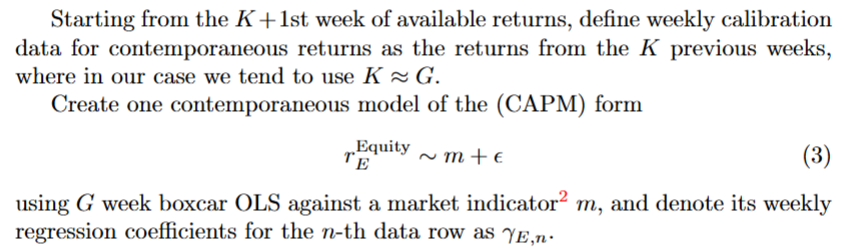

In [209]:
def boxcar_reg1(df, K, ticker):
    X = sm.add_constant(df['SPY'])
    y = df[f'{ticker}_equity']
    
    rolling_reg = RollingOLS(y, X, window=K)
    rolling_res = rolling_reg.fit()
    return rolling_res.params.iloc[:, 1]  # get beta coefficients


In [210]:
for ticker in tickers:

    data_summary[ticker]['Gamma'] = boxcar_reg1(data_summary[ticker],K,ticker)

* Equation 4:

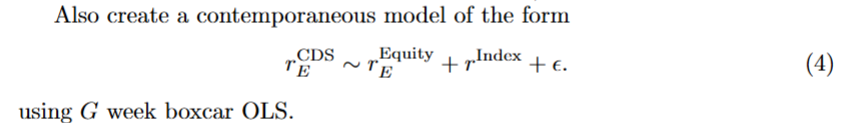

In [211]:
def boxcar_reg2(df, K, ticker):
    # Prepare predictors (X) and target (y)
    X = df[[f'{ticker}_equity', 'Index']]
    X = sm.add_constant(X)  # Add constant for intercept
    y = df[f'{ticker}_cds']
    
    # Perform rolling regression
    rolling_reg = RollingOLS(y, X, window=K)
    rolling_res = rolling_reg.fit()
    
    # Get all coefficients (intercept, equity beta, index beta)
    return rolling_res.params

In [212]:
for ticker in tickers:

    data_summary[ticker]['beta_Equity'] = boxcar_reg2(data_summary[ticker],K,ticker)[ticker+'_equity']
    data_summary[ticker]['beta_Index'] = boxcar_reg2(data_summary[ticker],K,ticker)['Index']

* Equation 5

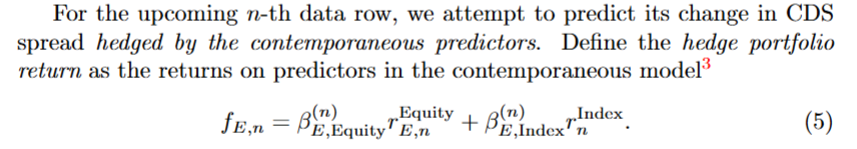

In [213]:
for ticker in tickers:
    data_summary[ticker]['f'] = data_summary[ticker]['beta_Equity']*data_summary[ticker][ticker+'_equity']+ data_summary[ticker]['beta_Index']*data_summary[ticker]['Index']

* Equation 6

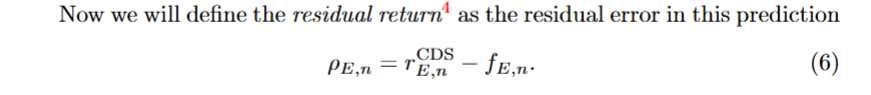

In [214]:
for ticker in tickers:
    data_summary[ticker]['res_ret'] = data_summary[ticker][ticker+'_cds'] - data_summary[ticker]['f']

* Equation 7

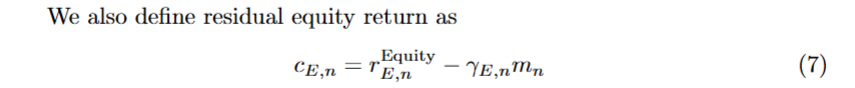

In [215]:
for ticker in tickers:
    data_summary[ticker]['res_equity_ret'] = data_summary[ticker][ticker+'_equity'] - data_summary[ticker]['Gamma']*data_summary[ticker]['SPY']
    data_summary[ticker] = data_summary[ticker].dropna()

* Equation 8 & 9

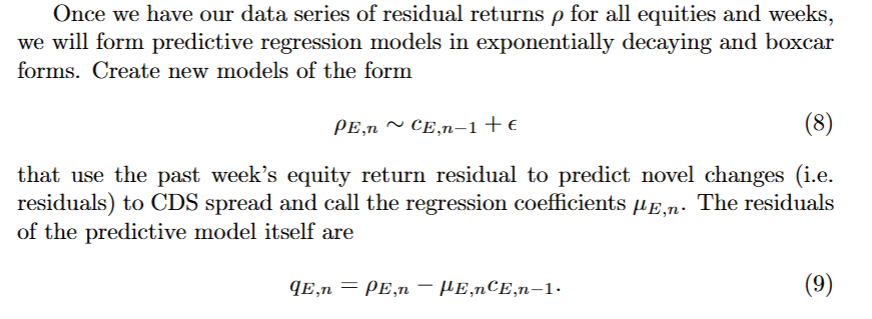

In [216]:
for ticker in tickers:

    data_summary[ticker]['res_equity_ret_1'] = data_summary[ticker]['res_equity_ret'].shift(1) 
    data_summary[ticker] =  data_summary[ticker].dropna()

C:\Users\steph\AppData\Local\Temp\ipykernel_13816\2134146622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\steph\AppData\Local\Temp\ipykernel_13816\2134146622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [217]:
data_summary['DD']

,DD_cds,DD_equity,SPY,Index,Gamma,beta_Equity,beta_Index,f,res_ret,res_equity_ret,res_equity_ret_1
date,,,,,,,,,,,
2018-03-21,0.188548,-0.022612,-0.013761,0.124185,1.122290,0.081517,1.412084,0.173516,0.015032,-0.007169,-0.027474
2018-03-28,0.171709,-0.074448,-0.039197,0.082180,1.255300,0.169522,1.480391,0.109038,0.062671,-0.025244,-0.007169
2018-04-04,0.035493,0.020510,0.014356,0.004043,1.329399,0.277231,1.519372,0.011828,0.023664,0.001425,-0.025244
2018-04-11,-0.029191,0.016329,0.000759,-0.045359,1.362983,0.353485,1.651417,-0.069135,0.039944,0.015295,0.001425
2018-04-18,-0.053849,0.051444,0.025136,-0.043035,1.737732,0.101817,1.683505,-0.067211,0.013362,0.007764,0.015295
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-11,-0.100478,0.061959,0.030644,-0.088861,0.584568,0.094490,1.374011,-0.116241,0.015763,0.044046,0.034024
2023-01-18,0.006120,-0.022964,-0.010189,-0.019579,0.754671,-0.055698,1.323263,-0.024629,0.030749,-0.015275,0.044046
2023-01-25,0.062225,0.004783,0.022631,0.012951,0.867732,0.027700,1.467529,0.019138,0.043086,-0.014855,-0.015275


## 3. Opportunity

In [218]:
def reg3(df,ticker):

    p = linreg.OLS(df['\u03C1'], df['c_1']).fit(params_only=True).params
    return pd.DataFrame(data=[p], index=[df.index[-1]])

def boxcar_reg3(df_box_dict, ticker_list, K):

    for ticker in ticker_list:

        b_coeffs = pd.concat([reg3(df_box_dict[ticker].iloc[i-K:i],ticker) for i in range(K, df_box_dict[ticker].shape[0])])
        df_box_dict[ticker]['\u03BC' + '_1_' +str(K)] = b_coeffs['c_1'] 
        df_box_dict[ticker]['predict_'+'\u03C1'+'_'+str(K)] = df_box_dict[ticker]['\u03BC'+'_1_'+str(K)] * df_box_dict[ticker]['c_1']
        df_box_dict[ticker]['q_'+str(K)] = df_box_dict[ticker]['\u03C1'] - df_box_dict[ticker]['predict_'+'\u03C1'+'_'+str(K)]

    return df_box_dict

def predictive_boxcar(df_data_dict, ticker_list, K_list):

    df_box_dict = {}

    for ticker in ticker_list:

        df_box_dict[ticker] = df_data_dict[ticker][['res_ret','res_equity_ret_1']]
        df_box_dict[ticker] = df_box_dict[ticker].rename(columns={'res_ret': '\u03C1','res_equity_ret_1':'c_1'})

    for K in K_list:
        df_box_dict = boxcar_reg3(df_box_dict, ticker_list, K)

    df_box_q = pd.DataFrame(columns = ticker_list, index=K_list)

    for ticker in ticker_list:
        for K in K_list:

            df_temp = df_box_dict[ticker][['\u03C1','predict_'+'\u03C1'+'_'+str(K)]].dropna()
            # print(len(df_temp))

            # df_box_q[ticker][K] = float(df_box_dict[ticker][['q_' + str(K)]].dropna().pow(2).sum())
            # print(len(df_box_dict[ticker].dropna()['\u03C1']))
            df_box_q[ticker][K] = r2_score(df_temp['\u03C1'], df_temp['predict_'+'\u03C1'+'_'+str(K)])

    return df_box_dict, df_box_q

In [219]:
K_list = [10,20, 30]

df_box_dict, df_box_q = predictive_boxcar(data_summary, tickers, K_list)

C:\Users\steph\AppData\Local\Temp\ipykernel_13816\2878690612.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\steph\AppData\Local\Temp\ipykernel_13816\2878690612.py:39: FutureWarning: ChainedAssignmentError: behaviour will change 

ρ = y; c_1 = x

In [220]:
class RollingRegression:
    def __init__(self, data_dict, window_sizes, tickers=None):
        self.data_dict = data_dict
        self.window_sizes = window_sizes
        self.tickers = tickers if tickers else list(data_dict.keys())
        
    def _prepare_data(self):
        prepared_data = {}
        for ticker in self.tickers:
            df = self.data_dict[ticker][['res_ret', 'res_equity_ret_1']].copy()
            prepared_data[ticker] = df
        return prepared_data
    
    def _compute_rolling_regression(self, df, window_size):
        y = df['res_ret'].values
        X = df['res_equity_ret_1'].values
        n = len(df)
        
        # Initialize arrays for results
        betas = np.full(n, np.nan)
        predictions = np.full(n, np.nan)
        residuals = np.full(n, np.nan)
        
        # Compute rolling regression
        for i in range(window_size - 1, n):
            y_window = y[i-window_size+1:i+1]
            X_window = X[i-window_size+1:i+1]
            
            # Skip if we have any NaN values
            if np.any(np.isnan(y_window)) or np.any(np.isnan(X_window)):
                continue
                
            try:
                # Fit regression
                model = OLS(y_window, X_window).fit(params_only=True)
                beta = model.params[0]
                
                # Store results
                betas[i] = beta
                predictions[i] = beta * X[i]
                residuals[i] = y[i] - predictions[i]
            except:
                continue
        
        return pd.DataFrame({
            f'beta_{window_size}': betas,
            f'pred_{window_size}': predictions,
            f'resid_{window_size}': residuals
        }, index=df.index)
    
    def compute_all_regressions(self):
        """Compute regressions for all tickers and window sizes."""
        # Prepare data
        processed_data = self._prepare_data()
        results_dict = {ticker: processed_data[ticker].copy() for ticker in self.tickers}
        
        # Calculate R² scores for each combination
        r2_scores = pd.DataFrame(index=self.window_sizes, columns=self.tickers)
        
        # Compute regressions for each ticker and window size
        for ticker in self.tickers:
            df = processed_data[ticker]
            
            for window in self.window_sizes:
                # Compute rolling regression results
                results = self._compute_rolling_regression(df, window)
                
                # Add results to the DataFrame
                results_dict[ticker] = pd.concat([results_dict[ticker], results], axis=1)
                
                # Calculate and store R² score
                mask = ~np.isnan(results[f'pred_{window}'])
                if mask.any():
                    r2 = r2_score(
                        df.loc[mask, 'res_ret'],
                        results.loc[mask, f'pred_{window}']
                    )
                    r2_scores.loc[window, ticker] = r2
        
        return results_dict, r2_scores


window_sizes = [10, 20, 30]
regression_analysis = RollingRegression(data_summary, window_sizes, tickers)
results_dict_box, r2_scores_box = regression_analysis.compute_all_regressions()

In [221]:
r2_scores_box['Mean R-squared'] = r2_scores_box.mean(axis=1)
r2_scores_box

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,T,WFC,WHR,XOM,XRX,Mean R-squared
10,0.138419,0.178424,0.08338,0.185299,0.123523,0.11527,0.233084,0.340783,0.237073,0.199618,0.08035,0.195716,0.181739,0.10211,0.172255,0.171136
20,0.09119,0.137262,0.065681,0.159426,0.090912,0.090548,0.147638,0.304942,0.180755,0.149323,0.041631,0.180924,0.101214,0.052681,0.144475,0.12924
30,0.068155,0.097527,0.054811,0.122936,0.051617,0.050127,0.112427,0.247949,0.164374,0.176681,0.019538,0.129331,0.087202,0.024163,0.124973,0.102121


<Axes: title={'center': 'SSR of Boxcar Regression'}, xlabel='Parameter Half Life', ylabel='SSR of Residual q'>

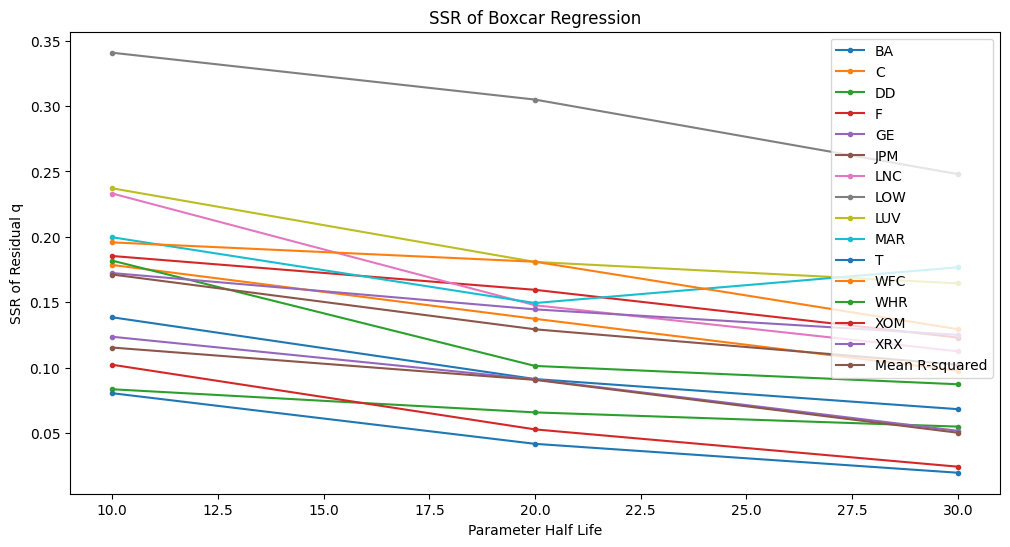

In [222]:
r2_scores_box.plot(title= "SSR of Boxcar Regression", ylabel = "SSR of Residual q", xlabel = "Parameter Half Life", figsize = (12,6),style='.-')

In [223]:
class ExponentialRegression:
    def __init__(self, data_dict, half_life_list, tickers=None):
        """
        Initialize exponential regression analysis.
        
        Parameters:
        -----------
        data_dict : dict
            Dictionary of DataFrames containing stock data
        half_life_list : list
            List of half-life values for exponential weighting
        tickers : list, optional
            List of stock tickers to analyze
        """
        self.data_dict = data_dict
        self.half_life_list = half_life_list
        self.tickers = tickers if tickers else list(data_dict.keys())
        
    def _prepare_data(self):
        """Prepare data by extracting relevant columns."""
        prepared_data = {}
        for ticker in self.tickers:
            df = self.data_dict[ticker][['res_ret', 'res_equity_ret_1']].copy()
            prepared_data[ticker] = df
        return prepared_data
    
    def _compute_weights(self, n_periods, half_life):
        """Compute exponential decay weights."""
        lambda_param = 2**(-1./half_life)
        threshold = 1. / (n_periods * 500)
        
        # Compute weights
        weights = lambda_param**np.arange(n_periods-1, -1, -1)
        
        # Filter weights above threshold
        valid_weights = weights[weights > threshold]
        
        # Calculate number of significant points
        significant_points = np.sum(weights > 1./20)
        
        return valid_weights, significant_points
    
    def _compute_exp_regression(self, data, weights):
        """Compute single exponential regression."""
        try:
            model = WLS(data['res_ret'], data['res_equity_ret_1'], 
                       weights=weights).fit(params_only=True)
            return model.params[0]
        except:
            return np.nan
    
    def _apply_exp_regression(self, df, half_life):
        """Apply exponential regression to entire dataset."""
        n = len(df)
        weights, min_points = self._compute_weights(n, half_life)
        n_weights = len(weights)
        
        # Initialize arrays for results
        betas = np.full(n, np.nan)
        predictions = np.full(n, np.nan)
        residuals = np.full(n, np.nan)
        
        # Compute exponential regression for each window
        for i in range(min_points, n):
            window_start = max(0, i - n_weights)
            window_data = df.iloc[window_start:i]
            window_weights = weights[-len(window_data):]
            
            beta = self._compute_exp_regression(window_data, window_weights)
            if not np.isnan(beta):
                betas[i] = beta
                predictions[i] = beta * df['res_equity_ret_1'].iloc[i]
                residuals[i] = df['res_ret'].iloc[i] - predictions[i]
        
        return pd.DataFrame({
            f'beta_{half_life}': betas,
            f'pred_{half_life}': predictions,
            f'resid_{half_life}': residuals
        }, index=df.index)
    
    def compute_all_regressions(self):
        """
        Compute exponential regressions for all tickers and half-lives.
        
        Returns:
        --------
        tuple
            (results_dict, r2_scores) containing regression results and R² values
        """
        # Prepare data
        processed_data = self._prepare_data()
        results_dict = {ticker: processed_data[ticker].copy() for ticker in self.tickers}
        
        # Calculate R² scores for each combination
        r2_scores = pd.DataFrame(index=self.half_life_list, columns=self.tickers)
        
        # Compute regressions for each ticker and half-life
        for ticker in self.tickers:
            df = processed_data[ticker]
            
            for half_life in self.half_life_list:
                # Compute regression results
                results = self._apply_exp_regression(df, half_life)
                
                # Add results to the DataFrame
                results_dict[ticker] = pd.concat([results_dict[ticker], results], axis=1)
                
                # Calculate and store R² score
                mask = ~np.isnan(results[f'pred_{half_life}'])
                if mask.any():
                    r2 = r2_score(
                        df.loc[mask, 'res_ret'],
                        results.loc[mask, f'pred_{half_life}']
                    )
                    r2_scores.loc[half_life, ticker] = r2
        
        return results_dict, r2_scores

half_life_list = [10, 20, 30]
exp_regression = ExponentialRegression(data_summary, half_life_list, tickers)
results_dict_exp, r2_scores_exp = exp_regression.compute_all_regressions()

C:\Users\steph\AppData\Local\Temp\ipykernel_13816\812234900.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
C:\Users\steph\AppData\Local\Temp\ipykernel_13816\812234900.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
C:\Users\steph\AppData\Local\Temp\ipykernel_13816\812234900.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
C:\Users\steph\AppData\Local\Temp\ipykernel_13816\812234900.py:48: FutureWarning: Series.__getitem__ tr

In [224]:
r2_scores_exp['Mean R-squared'] = r2_scores_exp.mean(axis=1)
r2_scores_exp

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,T,WFC,WHR,XOM,XRX,Mean R-squared
10,-0.064001,-0.115642,-0.009225,-0.269231,-0.011297,-0.068035,-0.101674,-0.125589,0.00628,0.02506,-0.012436,-0.117223,-0.027393,-0.014363,-0.000587,-0.060357
20,-0.077682,-0.087937,-0.004023,-0.155784,0.007356,-0.046236,-0.053557,-0.141301,0.023345,0.062876,0.00121,-0.097714,-0.021003,-0.019129,0.047756,-0.037455
30,-0.024105,-0.047614,-0.216038,0.000484,-0.006462,-0.021745,0.069839,-0.163527,0.007377,0.111303,0.013084,-0.075354,-0.031406,-0.104254,0.14269,-0.023048


<Axes: title={'center': 'SSR of Discounted Least Squares Regression'}, xlabel='Parameter Half Life', ylabel='SSR of Residual q'>

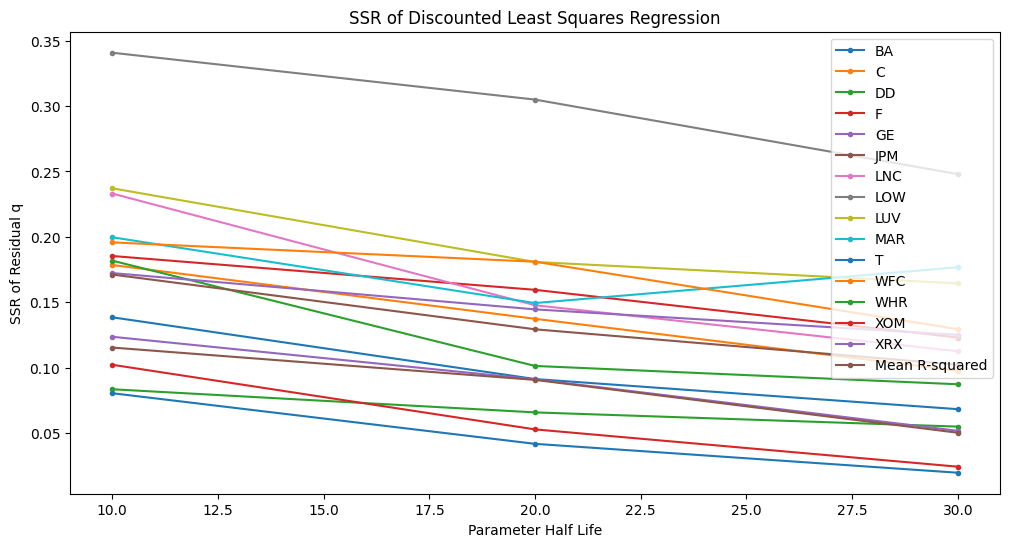

In [225]:
r2_scores_box.plot(title= "SSR of Discounted Least Squares Regression", ylabel = "SSR of Residual q", xlabel = "Parameter Half Life", figsize = (12,6),style='.-')

## 4. Analysis

In [226]:
class ResultsComparison:
    def __init__(self, results_dict_exp, results_dict_box, tickers):
        self.exp_results = results_dict_exp
        self.box_results = results_dict_box
        self.tickers = tickers
        
    def _get_parameter_lists(self):
        """Extract parameter lists from result column names."""
        # Sample ticker to get column names
        sample_ticker = self.tickers[0]
        exp_df = self.exp_results[sample_ticker]
        box_df = self.box_results[sample_ticker]
        
        # Get decay parameters (looking for beta_X columns)
        decay_params = sorted([
            int(col.split('_')[1]) 
            for col in exp_df.columns 
            if col.startswith('beta_')
        ])
        
        # Get boxcar parameters
        boxcar_params = sorted([
            int(col.split('_')[1]) 
            for col in box_df.columns 
            if col.startswith('beta_')
        ])
        
        return decay_params, boxcar_params
    
    def compare_methods(self):
        decay_params, boxcar_params = self._get_parameter_lists()
        comparison_data = []
        
        for ticker in self.tickers:
            exp_df = self.exp_results[ticker]
            box_df = self.box_results[ticker]
            
            # Original columns (y and x)
            y = exp_df['res_ret']
            x = exp_df['res_equity_ret_1']
            
            for decay_h in decay_params:
                # Exponential regression metrics
                exp_pred = exp_df[f'pred_{decay_h}'].dropna()
                exp_resid = exp_df[f'resid_{decay_h}'].dropna()
                exp_beta = exp_df[f'beta_{decay_h}'].dropna()
                
                if len(exp_pred) > 0:
                    exp_r2 = r2_score(y[exp_pred.index], exp_pred)
                    exp_std = exp_resid.std()
                    exp_mean_beta = exp_beta.mean()
                    exp_beta_std = exp_beta.std()
                else:
                    exp_r2 = exp_std = exp_mean_beta = exp_beta_std = np.nan
                
                for box_g in boxcar_params:
                    # Boxcar regression metrics
                    box_pred = box_df[f'pred_{box_g}'].dropna()
                    box_resid = box_df[f'resid_{box_g}'].dropna()
                    box_beta = box_df[f'beta_{box_g}'].dropna()
                    
                    if len(box_pred) > 0:
                        box_r2 = r2_score(y[box_pred.index], box_pred)
                        box_std = box_resid.std()
                        box_mean_beta = box_beta.mean()
                        box_beta_std = box_beta.std()
                    else:
                        box_r2 = box_std = box_mean_beta = box_beta_std = np.nan
                    
                    # Calculate residual correlation
                    common_idx = exp_resid.index.intersection(box_resid.index)
                    if len(common_idx) > 0:
                        resid_corr = np.corrcoef(
                            exp_resid[common_idx], 
                            box_resid[common_idx]
                        )[0, 1]
                    else:
                        resid_corr = np.nan
                    
                    comparison_data.append({
                        'ticker': ticker,
                        'decay_h': decay_h,
                        'boxcar_g': box_g,
                        'exp_r2': exp_r2,
                        'box_r2': box_r2,
                        'exp_resid_std': exp_std,
                        'box_resid_std': box_std,
                        'exp_mean_beta': exp_mean_beta,
                        'box_mean_beta': box_mean_beta,
                        'exp_beta_std': exp_beta_std,
                        'box_beta_std': box_beta_std,
                        'resid_correlation': resid_corr,
                        'r2_diff': exp_r2 - box_r2,
                        'std_ratio': exp_std / box_std if box_std != 0 else np.nan
                    })
        
        return pd.DataFrame(comparison_data)
    
    def get_summary_statistics(self, comparison_df=None):
        if comparison_df is None:
            comparison_df = self.compare_methods()
        
        # Overall summary by parameter combination
        param_summary = comparison_df.groupby(['decay_h', 'boxcar_g']).agg({
            'exp_r2': ['mean', 'std'],
            'box_r2': ['mean', 'std'],
            'resid_correlation': 'mean',
            'r2_diff': ['mean', 'std'],
            'std_ratio': 'mean'
        })
        
        # Best parameters by ticker
        best_params = comparison_df.loc[comparison_df.groupby('ticker')['exp_r2'].idxmax()]
        
        return {
            'parameter_summary': param_summary,
            'best_parameters': best_params,
            'full_comparison': comparison_df
        }

In [227]:
comparison = ResultsComparison(results_dict_exp, results_dict_box, tickers)
results = comparison.compare_methods()
summary = comparison.get_summary_statistics(results)

print("\nParameter Summary:")
print(summary['parameter_summary'])


Parameter Summary:
                    exp_r2              box_r2           resid_correlation  \
                      mean       std      mean       std              mean   
decay_h boxcar_g                                                             
10      10       -0.060357  0.076430  0.171136  0.068616          0.961274   
        20       -0.060357  0.076430  0.129240  0.065966          0.978514   
        30       -0.060357  0.076430  0.102121  0.062272          0.983006   
20      10       -0.037455  0.065011  0.171136  0.068616          0.952510   
        20       -0.037455  0.065011  0.129240  0.065966          0.973585   
        30       -0.037455  0.065011  0.102121  0.062272          0.984052   
30      10       -0.023048  0.094186  0.171136  0.068616          0.934371   
        20       -0.023048  0.094186  0.129240  0.065966          0.959816   
        30       -0.023048  0.094186  0.102121  0.062272          0.978439   

                   r2_diff           std_ra

In [228]:
print("\nBest Parameters by Ticker:")
print(summary['best_parameters'][['ticker', 'decay_h', 'boxcar_g', 'exp_r2', 'box_r2']])


Best Parameters by Ticker:
    ticker  decay_h  boxcar_g    exp_r2    box_r2
6       BA       30        10 -0.024105  0.138419
15       C       30        10 -0.047614  0.178424
21      DD       20        10 -0.004023  0.083380
33       F       30        10  0.000484  0.185299
39      GE       20        10  0.007356  0.123523
51     JPM       30        10 -0.021745  0.115270
60     LNC       30        10  0.069839  0.233084
63     LOW       10        10 -0.125589  0.340783
75     LUV       20        10  0.023345  0.237073
87     MAR       30        10  0.111303  0.199618
96       T       30        10  0.013084  0.080350
105    WFC       30        10 -0.075354  0.195716
111    WHR       20        10 -0.021003  0.181739
117    XOM       10        10 -0.014363  0.102110
132    XRX       30        10  0.142690  0.172255


For Boxcar Regression:

Shorter windows (10 periods) consistently produce better results than longer windows
The best performance is achieved with a 10-period window, giving a mean R² of 0.171
LOW stock shows the highest R² (0.341) with a 10-period window
T stock shows the lowest R² (0.080) with a 10-period window

For Exponential Decay:

Longer half-lives (30 periods) generally perform better than shorter ones
The mean R² improves from -0.060 (10-period) to -0.023 (30-period)
XRX shows the best performance with R² of 0.143 at 30-period half-life
LOW shows the worst performance with R² of -0.126 at 10-period half-life

The results suggest that using a 10-period Boxcar window might be most effective for trading strategies.
Different sectors show varying levels of predictability, suggesting sector-specific approaches might be beneficial.
The high residual correlation between methods suggests that using both might not provide significant diversification benefits.

* Let's make more analysis on LNC, which is relatively better-performanced

<Figure size 2400x800 with 0 Axes>

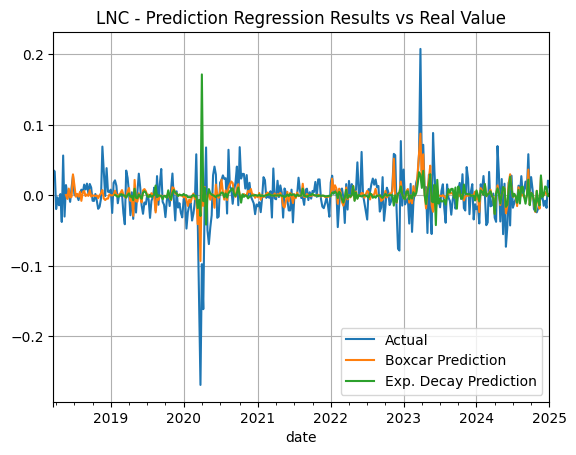

<Figure size 2400x800 with 0 Axes>

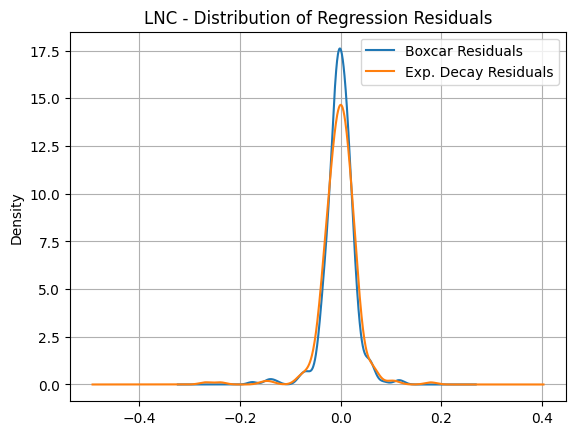


Performance Metrics:
                                          Count      Mean       Vol  Skewness  \
Boxcar (K = 10)                             346 -0.002117  0.029595 -1.015874   
Discounted Least Squares (Half life = 10)   311 -0.002884   0.03681 -1.907033   

                                            Kurtosis R-squared  
Boxcar (K = 10)                             7.758077  0.233084  
Discounted Least Squares (Half life = 10)  16.374475 -0.101674  


In [229]:
import matplotlib.pyplot as plt
from scipy import stats

def analyze_stock_performance(ticker, df_box_dict, df_exp_dict, df_box_q, df_exp_q, box_window=10, exp_halflife=10):
    """
    Analyze performance metrics for a given stock using both regression methods.
    """
    # Prepare boxcar regression results
    df_box = df_box_dict[ticker]
    df_box_analysis = df_box[['res_ret', 'res_equity_ret_1', 
                             f'beta_{box_window}', f'pred_{box_window}', 
                             f'resid_{box_window}']]
    df_box_analysis.columns = ['y', 'x', 'beta_box', 'pred_box', 'q_box']
    
    # Prepare exponential regression results
    df_exp = df_exp_dict[ticker]
    df_exp_analysis = df_exp[['res_ret', 'res_equity_ret_1', 
                             f'beta_{exp_halflife}', f'pred_{exp_halflife}', 
                             f'resid_{exp_halflife}']]
    df_exp_analysis.columns = ['y', 'x', 'beta_exp', 'pred_exp', 'q_exp']
    
    # Combine results
    df_combined = df_box_analysis.join(df_exp_analysis[['beta_exp', 'pred_exp', 'q_exp']])
    
    # Calculate performance metrics
    metrics = calculate_performance_metrics(
        df_combined, 
        df_box_q, 
        df_exp_q, 
        ticker, 
        box_window, 
        exp_halflife
    )
    
    # Create visualizations
    create_prediction_plot(df_combined, ticker)
    create_residual_plot(df_combined, ticker)
    
    return df_combined, metrics

def calculate_performance_metrics(df, df_box_q, df_exp_q, ticker, box_window, exp_halflife):
    """
    Calculate various performance metrics for both regression methods.
    """
    # Prepare metrics DataFrame
    metrics = pd.DataFrame(
        index=['Count', 'Mean', 'Vol', 'Skewness', 'Kurtosis', 'R-squared'],
        columns=[f'Boxcar (K = {box_window})', f'Discounted Least Squares (Half life = {exp_halflife})']
    )
    
    # Calculate metrics for both methods
    for method, col in [('Boxcar', 'q_box'), ('Discounted Least Squares', 'q_exp')]:
        residuals = df[col].dropna()
        col_name = f"{'Boxcar'} (K = {box_window})" if method == 'Boxcar' else f"Discounted Least Squares (Half life = {exp_halflife})"
        
        metrics.loc['Count', col_name] = len(residuals)
        metrics.loc['Mean', col_name] = float(residuals.mean())
        metrics.loc['Vol', col_name] = float(residuals.std())
        metrics.loc['Skewness', col_name] = float(residuals.skew())
        metrics.loc['Kurtosis', col_name] = float(residuals.kurtosis())
    
    # Add R-squared values
    metrics.loc['R-squared', f'Boxcar (K = {box_window})'] = df_box_q[ticker][box_window]
    metrics.loc['R-squared', f'Discounted Least Squares (Half life = {exp_halflife})'] = df_exp_q[ticker][exp_halflife]
    
    return metrics.T

def create_prediction_plot(df, ticker):
    """
    Create plot comparing predictions with actual values.
    """
    plt.figure(figsize=(24, 8))
    df[['y', 'pred_box', 'pred_exp']].plot(title=f"{ticker} - Prediction Regression Results vs Real Value")
    plt.grid(True)
    plt.legend(['Actual', 'Boxcar Prediction', 'Exp. Decay Prediction'])
    plt.show()

def create_residual_plot(df, ticker):
    """
    Create density plot of regression residuals.
    """
    plt.figure(figsize=(24, 8))
    df[['q_box', 'q_exp']].plot(kind='kde', title=f"{ticker} - Distribution of Regression Residuals")
    plt.grid(True)
    plt.legend(['Boxcar Residuals', 'Exp. Decay Residuals'])
    plt.show()


df_lnc, lnc_metrics = analyze_stock_performance('LNC', results_dict_box, results_dict_exp, r2_scores_box, r2_scores_exp)
print("\nPerformance Metrics:")
print(lnc_metrics)

The Boxcar method is clearly superior for LNC:

Better coverage (more observations);
More accurate (smaller mean error);
More consistent (lower volatility);
More robust (less extreme outliers);
Much better predictive power (positive vs negative R²);


Risk Considerations:

Both methods show significant negative skewness and high kurtosis;
This suggests risk of unexpected large negative movements;
The exponential method is particularly vulnerable to extreme events;